<a href="https://colab.research.google.com/github/christymarc/BeachImageClassification/blob/main/BeachClassificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import fastai
from pathlib import Path
from PIL import Image
from urllib import request
from io import BytesIO
import pandas as pd
import urllib.request
import requests
import tensorflow as tf
from keras.preprocessing.image import *
import os
import shutil
import cv2
import imghdr

In [ ]:
CLASSES = ['cleanBeach', 'dirtyBeach']
HEADERS = {
    "user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36"
}
VALID_PCT = 0.2
IMG_SIZE = 224
BATCH_SIZE = 32
DATA_PATH = Path('/content/data/')

In [ ]:
def loadImage(URL):
    with urllib.request.urlopen(URL) as url:
        img = image.load_img(BytesIO(url.read()), target_size=(IMG_SIZE, IMG_SIZE))
    return image.img_to_array(img)

Loading in Clean Beach Data

In [ ]:
file = 'cleanBeaches.txt'
opened_file = open(DATA_PATH/file, 'r')
lines = opened_file.readlines()

In [ ]:
len(lines)

775

In [ ]:
count = 0
path = "data/cleanBeach/"
for line in lines:
    count += 1
    line = line.strip()
    try:
        r = requests.get(line, headers=HEADERS)
        with open(path + f'{count:05}' + '.jpg', 'wb') as outfile:
            outfile.write(r.content)
    except requests.ConnectionError: 
        pass

Loading in Dirty Beach Data

In [12]:
file = 'dirtyBeaches.txt'
opened_file = open(DATA_PATH/file, 'r')
lines = opened_file.readlines()

In [13]:
len(lines)

588

In [14]:
count = 0
path = "data/dirtyBeach/"
for line in lines:
    count += 1
    line = line.strip()
    try:
        r = requests.get(line, headers=HEADERS)
        with open(path + f'{count:05}' + '.jpg', 'wb') as outfile:
            outfile.write(r.content)
    except requests.ConnectionError: 
        pass

Delete extra class (".ipynb_checkpoints")

In [15]:
os.listdir("/content/data")

['cleanBeaches.txt', 'dirtyBeaches.txt', 'cleanBeach', 'dirtyBeach']

In [17]:
shutil.rmtree("/content/data/cleanBeach/.ipynb_checkpoints")
shutil.rmtree("/content/data/dirtyBeach/.ipynb_checkpoints")

FileNotFoundError: ignored

In [ ]:
shutil.rmtree("data/.ipynb_checkpoints") #be careful with shutil.rmtree() because it deletes every tree in that path. In other words, do not make mistakes.

In [ ]:
os.listdir("/content/data")

ensuring correct image type

In [20]:
def check_images(s_dir, ext_list):
    bad_images=[]
    bad_ext=[]
    s_list= os.listdir(s_dir)
    for klass in s_list:
        klass_path=os.path.join (s_dir, klass)
        print ('processing class directory ', klass)
        if os.path.isdir(klass_path):
            file_list=os.listdir(klass_path)
            for f in file_list:               
                f_path=os.path.join (klass_path,f)
                tip = imghdr.what(f_path)
                if ext_list.count(tip) == 0:
                  bad_images.append(f_path)
                if os.path.isfile(f_path):
                    try:
                        img=cv2.imread(f_path)
                        shape=img.shape
                    except:
                        print('file ', f_path, ' is not a valid image file')
                        bad_images.append(f_path)
                else:
                    print('*** fatal error, you a sub directory ', f, ' in class directory ', klass)
        else:
            print ('*** WARNING*** you have files in ', s_dir, ' it should only contain sub directories')
    return bad_images, bad_ext

source_dir =r'/content/data'
good_exts=['jpg', 'png', 'jpeg', 'gif', 'bmp' ] # list of acceptable extensions
bad_file_list, bad_ext_list=check_images(source_dir, good_exts)
if len(bad_file_list) !=0:
    print('improper image files are listed below')
    for i in range (len(bad_file_list)):
        print(bad_file_list[i])
        # Load image
        image = cv2.imread(bad_file_list[i])
        if (image is not None):
          # Save as proper .jpg image
          cv2.imwrite(bad_file_list[i], image, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
        elif (os.path.exists(bad_file_list[i])):
          os.remove(bad_file_list[i])
          print("deleted file: " + bad_file_list[i])
else:
    print(' no improper image files were found')

processing class directory  cleanBeaches.txt
*** WARNING*** you have files in  /content/data  it should only contain sub directories
processing class directory  dirtyBeaches.txt
*** WARNING*** you have files in  /content/data  it should only contain sub directories
processing class directory  cleanBeach
file  /content/data/cleanBeach/00311.jpg  is not a valid image file
processing class directory  dirtyBeach
improper image files are listed below
/content/data/cleanBeach/00311.jpg


Split data into training and verification data

In [21]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_PATH,
  validation_split=VALID_PCT,
  subset="training",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)

Found 1343 files belonging to 2 classes.
Using 1075 files for training.


In [22]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_PATH,
  validation_split=VALID_PCT,
  subset="validation",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)

Found 1343 files belonging to 2 classes.
Using 268 files for validation.


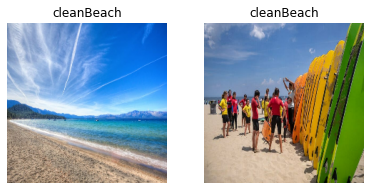

In [26]:
import matplotlib.pyplot as plt
import matplotlib.figure
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(2):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASSES[labels[i]])
    plt.axis("off")